<a href="https://colab.research.google.com/github/Haribansha/learning-python-2896241/blob/main/Field_Bioreactor_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the V-notch flow conversion function.
def v_notch_flow(h_m):
  #V_notch parameters for Brian Corkill bioreactor
  h = h_m/0.0254  # converting to inch from m
  L = 8 # inch
  B5 = 3 # Number of 5 inch board installed
  B7 = 2 # Number of 7 inch board installed
  Db = (B5*5+B7*7) # Blocked depth by boards 29 inch (below V notch board)
  V_l = 5.5# V notch starting height from bottom of V-notch board
  V_cr = 6.5 # Crest height of V-notch
  H = 71 #Max possible actual depth = Height of chamber  inch
  h = min(h, H)
  H_weir = Db+ V_l + V_cr # Max applicable depth of flat weir equation from the bottom
  H_v_eff = np.where((h - (Db + V_l)) > 0, np.minimum(h - (Db + V_l), H_weir), 0)
  H_weir = np.where(h< H_weir, 0, h-H_weir)

  """ Calculate Q for V_notch and flat weir and add them together """
  Qv = 1.057*(H_v_eff*2.54)**2.057
  Q_weir = 0.021*(L*2.54)*(H_weir*2.54)**1.37
  Q = Qv + Q_weir

  return Q



In [57]:
WL_file_path = "Corkill_Water level.xlsx"
df = pd.read_excel(WL_file_path, sheet_name = "Corkill_Water level_Inflow")

# Check available sheet names
xl = pd.ExcelFile(WL_file_path)
print(xl.sheet_names)
inflow_sheet = "Corkill_Water level_Inflow"
outflow_sheet = "Corkill_Water level_Outlflow"
df.head()



['Corkill_Water level_Inflow', 'Corkill_Water level_Outlflow', 'Corkill_Water level_Downstream', 'Filled_outflow with regression', 'Regression equation for missing']


,Date Time,Abs Pressure,Temp,Baro Pressure,Sensor depth,Unnamed: 5
0,2022-10-06 12:00:00,99.177,15.760,99.169,0.001,NaN
1,2022-10-06 12:15:00,99.163,15.664,99.018,0.015,NaN
2,2022-10-06 12:30:00,99.163,15.664,99.001,0.017,NaN
3,2022-10-06 12:45:00,99.153,15.664,98.995,0.016,NaN
4,2022-10-06 13:00:00,99.132,15.664,98.966,0.017,NaN


In [12]:
# from google.colab import sheets
# sheet = sheets.InteractiveSheet(df=WL_df)

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------
# File path for the Excel file
# -------------------------------------------
WL_file_path = "Corkill_Water level.xlsx"

# -------------------------------------------
# Process Inflow Data
# -------------------------------------------
df_inflow = pd.read_excel(WL_file_path, sheet_name=inflow_sheet)
df_inflow['Date Time'] = pd.to_datetime(df_inflow['Date Time'])
sensor_depth_col = 'Sensor depth'

df_inflow['Flow'] = df_inflow[sensor_depth_col].apply(v_notch_flow)  # Flow in m³/s
df_inflow['Date'] = df_inflow['Date Time'].dt.date
df_inflow['Volume_15min'] = df_inflow['Flow'] * (15 * 60)  # Volume in m³

daily_inflow = df_inflow.groupby('Date')['Volume_15min'].sum().reset_index()
daily_inflow.rename(columns={'Volume_15min': 'Daily_Volume_Inflow_m3'}, inplace=True)
daily_inflow['Daily_Flow_Inflow_LPS'] = (daily_inflow['Daily_Volume_Inflow_m3'] * 1000) / 86400

# -------------------------------------------
# Process Outflow Data
# -------------------------------------------
df_outflow = pd.read_excel(WL_file_path, sheet_name=outflow_sheet)
df_outflow['Date Time'] = pd.to_datetime(df_outflow['Date Time'])
df_outflow['Flow'] = df_outflow[sensor_depth_col].apply(v_notch_flow)  # Flow in m³/s
df_outflow['Date'] = df_outflow['Date Time'].dt.date
df_outflow['Volume_15min'] = df_outflow['Flow'] * (15 * 60)  # Volume in m³

daily_outflow = df_outflow.groupby('Date')['Volume_15min'].sum().reset_index()
daily_outflow.rename(columns={'Volume_15min': 'Daily_Volume_Outflow_m3'}, inplace=True)
daily_outflow['Daily_Flow_Outflow_LPS'] = (daily_outflow['Daily_Volume_Outflow_m3'] * 1000) / 86400

# -------------------------------------------
# Combine Inflow and Outflow Daily Data
# -------------------------------------------
daily_flow_combined = pd.merge(daily_inflow, daily_outflow, on='Date', how='outer')
daily_flow_combined.sort_values('Date', inplace=True)

# Display the first few rows of the combined daily results
print(daily_flow_combined.head())

# Optionally, save the combined daily results to a new Excel file
daily_flow_combined.to_excel('daily_flow_combined_results.xlsx', index=False)



         Date  Daily_Volume_Inflow_m3  Daily_Flow_Inflow_LPS  \
0  2022-10-06                     0.0                    0.0   
1  2022-10-07                     0.0                    0.0   
2  2022-10-08                     0.0                    0.0   
3  2022-10-09                     0.0                    0.0   
4  2022-10-10                     0.0                    0.0   

   Daily_Volume_Outflow_m3  Daily_Flow_Outflow_LPS  
0                      0.0                     0.0  
1                      0.0                     0.0  
2                      0.0                     0.0  
3                      0.0                     0.0  
4                      0.0                     0.0  


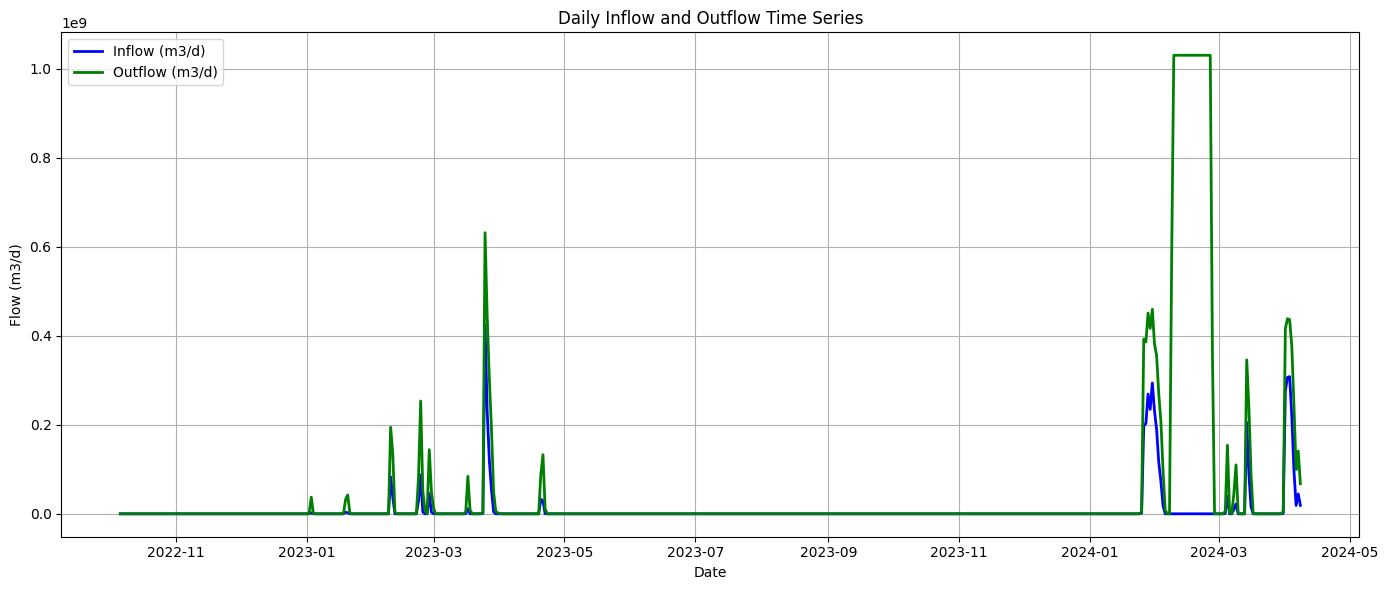

<Figure size 640x480 with 0 Axes>

In [59]:

# -------------------------------------------
# Plotting Daily Inflow and Outflow Time Series
# -------------------------------------------
plt.figure(figsize=(14, 6))

# Plot inflow
plt.plot(daily_flow_combined['Date'], daily_flow_combined['Daily_Volume_Inflow_m3'],
         label='Inflow (m3/d)', color='blue', linewidth=2)

# Plot outflow
plt.plot(daily_flow_combined['Date'], daily_flow_combined['Daily_Volume_Outflow_m3'],
         label='Outflow (m3/d)', color='green', linewidth=2)

# Formatting the plot
plt.title('Daily Inflow and Outflow Time Series')
plt.xlabel('Date')
plt.ylabel('Flow (m3/d)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# Optionally, save the plot
plt.savefig('daily_inflow_outflow_timeseries.png', dpi=300)